## Board game recommendation engine using SIngle Value Decomposition
### with unrated game cells filled using imputer

#### John Burt


#### Purpose of this notebook:

Implement a board game recommender using a game rating dataset from the boardgamegeek.com website. 

#### The method:

- Load data into a pandas dataframe from provided csv files.

- Convert the data into a games(rows) X users(cols) rating matrix, with NaNs where users haven't rated games (majority of cells).

- Drop users who rated too few games, or gave outlier ratings.

- Replace the NaNs with estimated ratings values using scikit.learn imputer. 

- Run the filled matrix through Single Value Decomposition (SVD) to generate N feature dimensions that describe each game. The result is a set of N dimensional coordinates for each game.

- The recommender takes a user specified game title and uses the SVD coordinates to present the games that are nearest neighbors as recommendations.

#### Filling out the ratings matrix
In this notebook, I try two different methods for filling in the NaNs representing unrated games. It turns out that this step is very important for getting good results.

- Using an imputer to fill in NaNs with mean values. Besides replacing NaNs with 0s, this is the simplest method, but it doesn't necessarily give good results.

- Using a weighted Alternating Least Squares method (ALS) to estimate user ratings for all games. This method is very computationally expensive, but it seems to give better results.

#### Clustering the game features
Additionally, I will run a KMeans cluster analysis on the SVD features to see whether we can separate the games into meaningful groupings based on their coordinates within the feature space.

## load data from csv file

- Set up plot environment.
- boardgame rating data from csv into pandas dataframe


In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

pd.options.display.max_rows = 100

# load the boardgame user data
#userdata = pd.read_csv('boardgame-users.csv') # NOTE: ALS can take a LONG time to process this many users!
#userdata = pd.read_csv('boardgame-elite-users.csv')
userdata = pd.read_csv('boardgame-frequent-users.csv')

# rename the userID column
userdata=userdata.rename(columns = {"Compiled from boardgamegeek.com by Matt Borthwick":'userID'})

# load the boardgame title data
titledata = pd.read_csv('boardgame-titles.csv')

# rename the gameID column
titledata=titledata.rename(columns = {"boardgamegeek.com game ID":'gameID'})

# for titledata set game ID as the index
titledata = titledata.set_index("gameID")

#print(userdata.head())
#print("\n", titledata.head())


Pivot user rating data, creating users (row) x gameID (col) x rating

In [2]:
# pivot the user data to create rows of users, with columns games. 
# If a user rated a game, it will be at user x game and if not, then the cell will be NAN
#rp = userdata.pivot(index="userID", columns="gameID", values="rating")
rp = userdata.pivot(index="gameID", columns="userID", values="rating")
#rp.head()

## Do some filtering.

The purpose of this filtering is to 1) reduce the dataset size but keep the most ratings, and 2) remove potentially malicious and outlier users (people who rate everything a narrow range of values, or rate everything low).

Drop users:
- Who have rated < threshold # games
- Whose scores have range < threshold
- Whose score max < threshold

Note: this filtering is mostly only useful for the all users data, which has a lot of users who rate few games or only rate high or low, with no range of preference. It has very little effect on the other data sets.

In [3]:
mincount = 100 # min num ratings threshold
minrange = 5 # min rating range threshold
minmax = 7 # max rating min threshold

# number of ratings by each user
usercounts = np.count_nonzero(~np.isnan(rp.values),0)

# drop users with fewer than mincount ratings
rp_filt = rp.drop(rp.columns[usercounts<mincount], axis=1)

print("dropped %d < %d ratings"%(rp.shape[1]-rp_filt.shape[1], mincount))

# rating range for each user
userrange = rp_filt.max(axis=0) - rp_filt.min(axis=0)

oldnumusers = rp_filt.shape[1]

# drop users with rating range less than minrange
rp_filt = rp_filt.drop(rp_filt.columns[userrange<minrange], axis=1)

print("dropped %d < %d rating range"%(oldnumusers-rp_filt.shape[1], minrange))

# max rating range for each user
usermax = rp_filt.max(axis=0)

oldnumusers = rp_filt.shape[1]

# drop users with rating max less than minmax
rp_filt = rp_filt.drop(rp_filt.columns[usermax<minmax], axis=1)

print("dropped %d max rating < %d"%(oldnumusers-rp_filt.shape[1],minmax))

print("\ntotal #users now = %d"%(rp_filt.shape[1]))

dropped 0 < 100 ratings
dropped 87 < 5 rating range
dropped 0 max rating < 7

total #users now = 2386


Range user scores between 1 - 10.

This ensures that all users have the same ratings range. This seems to help the SVD produce more meaningful feature dimensions.

In [4]:
userratingmax = rp_filt.max(axis=0)
userratingmin = rp_filt.min(axis=0)
rp_fixed = 9 * (rp_filt - userratingmin) / (userratingmax-userratingmin) + 1

Fill the unrated cells in the matrix, currently filled with NaNs, with mean game rating across all users who rated the game.

In [5]:
from sklearn.preprocessing import Imputer

# replace NaNs (unrated games) with game's mean rating
rp_imputed = Imputer(missing_values='NaN', strategy='mean', axis=1).transform(rp_fixed)

## Compute the Truncated SVD. 

This proces will result in a set of feature values for each game, allowing them to be plotted onto a map that theoretically indicates which games are related to each other by receiving similar ratings by similar users. 

In [6]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA, TruncatedSVD, NMF

# number of feature dimensions for analysis
numdims = 4

coords = TruncatedSVD(n_components=numdims).fit_transform(rp_imputed)

Plot the games in the SVD feature space:

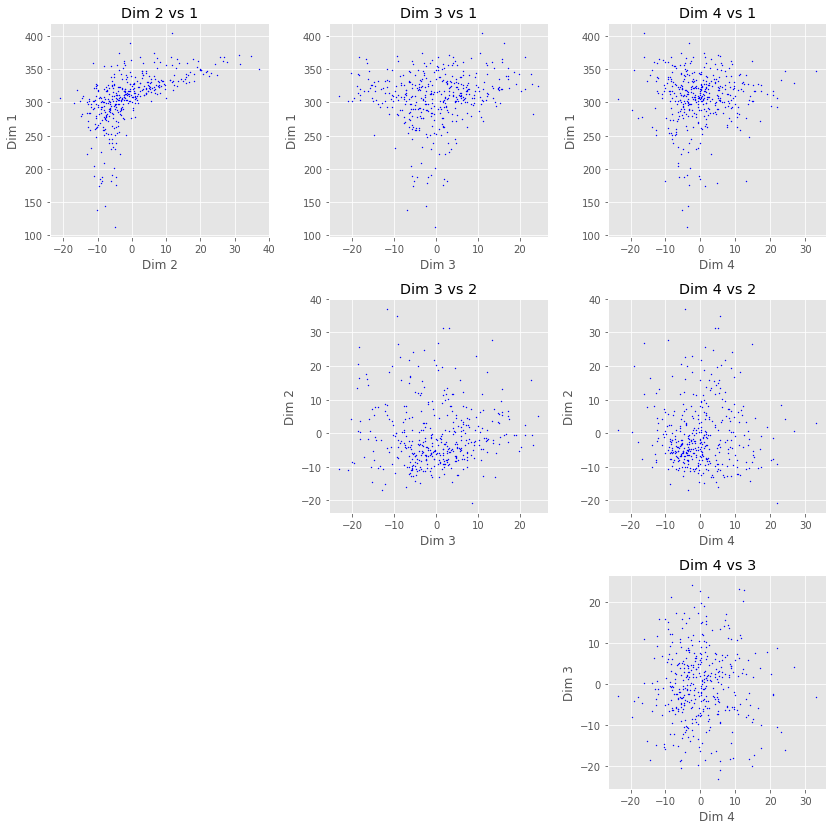

In [7]:
numdims = coords.shape[1]

plt.figure(figsize=(15, 15))
s = 2
axrange = 30

numrows = numdims
for i in range(numrows):
    for j in range(i+1):
        if i != j:
            plotnum = j*(numrows)+i+1
            plt.subplot(numrows, numrows, plotnum)
            sa = plt.scatter(coords[:,i],coords[:,j], color='b', s=s, lw=0, label='PCA')
            ta = plt.title("Dim %d vs %d"%(i+1,j+1))
            xl = plt.xlabel("Dim %d"%(i+1))
            yl = plt.ylabel("Dim %d"%(j+1))
            #plt.xlim([-axrange,axrange])
            #plt.ylim([-axrange,axrange])
            plt.tight_layout()

### Functions to recommend games based on a selected title and the SVD coordinates for all games.

The method: 
- calculate the euclidean distance between target game and all others.
- sort the distances.
- return indices of games 

In [8]:
from scipy.spatial.distance import cdist

def find_nearest_neighbors(coords, x, numnearest):
    
    # get euclidean distances of all points to x    
    dists = cdist(np.reshape(x,(1,-1)),coords) 
    
    ind, = np.argsort(dists)

    # return the numnearest nearest neighbors
    return ind[:numnearest]
    
def recommend_games(targettitle, gametitles, coords, num2rec):
    
    # get coords of target title
    targetcoord = coords[gametitles==targettitle,:]
    
    # find nearest neighbors
    ind = find_nearest_neighbors(coords, targetcoord, num2rec+1)
    
    # Note: first entry will be the target title (distance 0)
    return ind[1:]

## Recommender

Given a single game title, recommend N other games. The Recommender simply looks for the nearest games in the SVD feature space and prints them out.

Test the recommender using a range of different kinds and weights of games. 

In [9]:
targettitles = [
    "Monopoly", # low rated mass market
    "Apples to Apples", # higher rated mass market and party
    "Zombicide", # Thematic co-op, adult theme, miniatures
    "Mice and Mystics", # Thematic co-op, family theme, miniatures
    "Love Letter", # social deduction, party, "filler"
    "Ticket to Ride", # very light-weight gateway eurogame 
    "Catan", # light-weight gateway eurogame
    "Carcassonne", # light-weight gateway eurogame
    "Agricola", # mid-weight eurogame 
    "Terraforming Mars", # mid-heavy-weight eurogame
    "Caverna: The Cave Farmers" # heavy eurogame
    ]

# number of recommended games to present
num2recommend = 5

# get game titles from titledata
gametitles = titledata.title[rp.index].values

# give recommendations for each target game 
for title in targettitles:
    recs = recommend_games(title, gametitles, coords, num2recommend)
    print('If you like %s, you should try: %s\n' % 
          (title, ', '.join(gametitles[recs])))
        

If you like Monopoly, you should try: Battleship, The Game of Life, UNO, Exploding Kittens, Fluxx

If you like Apples to Apples, you should try: Stratego, Monopoly Deal Card Game, Zombie Dice, Cards Against Humanity, Scattergories

If you like Zombicide, you should try: Dungeons & Dragons: Castle Ravenloft Board Game, Terror in Meeple City, Discworld: Ankh-Morpork, Space Hulk: Death Angel – The Card Game, Runebound (Second Edition)

If you like Mice and Mystics, you should try: Blood Bowl: Team Manager – The Card Game, Descent: Journeys in the Dark, Pandemic: The Cure, Neuroshima Hex!, Risk Legacy

If you like Love Letter, you should try: Flash Point: Fire Rescue, Dixit, Small World, Takenoko, Thebes

If you like Ticket to Ride, you should try: Ticket to Ride: Europe, Pandemic, Carcassonne, Splendor, San Juan

If you like Catan, you should try: Alhambra, Bohnanza, Kingdom Builder, Lost Cities, Roll Through the Ages: The Bronze Age

If you like Carcassonne, you should try: Splendor, Tic

## Alternating Least Squares method

Here we implement a weighted Alternating Least Squares algorithm. I found this at the source below. It seems popular as a method of inferring missing ratings to fill ratings matrices prior to feeding them into PCA or SVD analyses. The method attempts to solve for a specified number of missing factors that influence users to rate the games as they do, then uses the factors to guess how users would rate all of the other games they haven't rated. For more on this method, see the link below.

I got the idea to use this and adapted the code from:
https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/

### WARNING: this function is computationally heavy. It can take a while to complete and if the dataset is too large, the code will barf out with a memory error.

In [11]:
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

def do_ALS(Q, n_iterations=10, lambda_=0.1, n_factors=100, weighted=True ):
    
    W = Q>0.5
    W[W == True] = 1
    W[W == False] = 0
    # To be consistent with our Q matrix
    W = W.astype(np.float64, copy=False)

    m, n = Q.shape

    X = 5 * np.random.rand(m, n_factors) 
    Y = 5 * np.random.rand(n_factors, n)

    if not weighted:
        errors = []
        for ii in range(n_iterations):
            X = np.linalg.solve(np.dot(Y, Y.T) + lambda_ * np.eye(n_factors), 
                                np.dot(Y, Q.T)).T
            Y = np.linalg.solve(np.dot(X.T, X) + lambda_ * np.eye(n_factors),
                                np.dot(X.T, Q))
            if ii % 2 == 0:
                print("iteration %d, error = %4.2f"%(ii,get_error(Q, X, Y, W)))

            errors.append(get_error(Q, X, Y, W))
        Q_hat = np.dot(X, Y)
        print("Error of rated games: %4.2f"%(get_error(Q, X, Y, W)))

    else:
        errors = []
        for ii in range(n_iterations):
            for u, Wu in enumerate(W):
                X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors),
                                       np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
            for i, Wi in enumerate(W.T):
                Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors),
                                         np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
            if ii % 2 == 0:
                print("iteration %d, error = %4.2f"%(ii,get_error(Q, X, Y, W)))
            errors.append(get_error(Q, X, Y, W))

        print("iteration %d, error = %4.2f"%(ii,get_error(Q, X, Y, W)))
        Q_hat = np.dot(X,Y)

    return Q_hat, X, Y, errors

## Compute the missing ratings using the ALS algorithm.

The parameters given seem to work OK for this dataset.

iteration 0, error = 585646.94
iteration 2, error = 326098.27
iteration 4, error = 283953.37
iteration 6, error = 266124.22
iteration 8, error = 256102.17
iteration 9, error = 252582.17


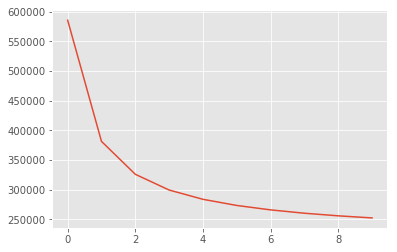

In [12]:
lambda_ = 0.1
n_factors = 100
n_iterations = 10

# replace NaNs (unrated games) with zeros
rp_fixed2 = rp_fixed.fillna(0)

# Q_hat is our filled in matrix, errors lets us plot how things went
Q_hat, X, Y, errors = do_ALS(rp_fixed2.values, n_iterations=n_iterations, lambda_=lambda_, n_factors=n_factors, weighted=True )

plt.plot(errors);

## Compute the Truncated SVD. 

This proces will result in a set of feature values for each game, allowing them to be plotted onto a map that theoretically indicates which games are related to each other by receiving similar ratings by similar users. 

In [13]:
from sklearn.decomposition import PCA, SparsePCA, KernelPCA, TruncatedSVD, NMF

# number of dimensions for analysis
numdims = 4

coords = TruncatedSVD(n_components=numdims).fit_transform(Q_hat)

Plot the resulting PCA / SVD output 

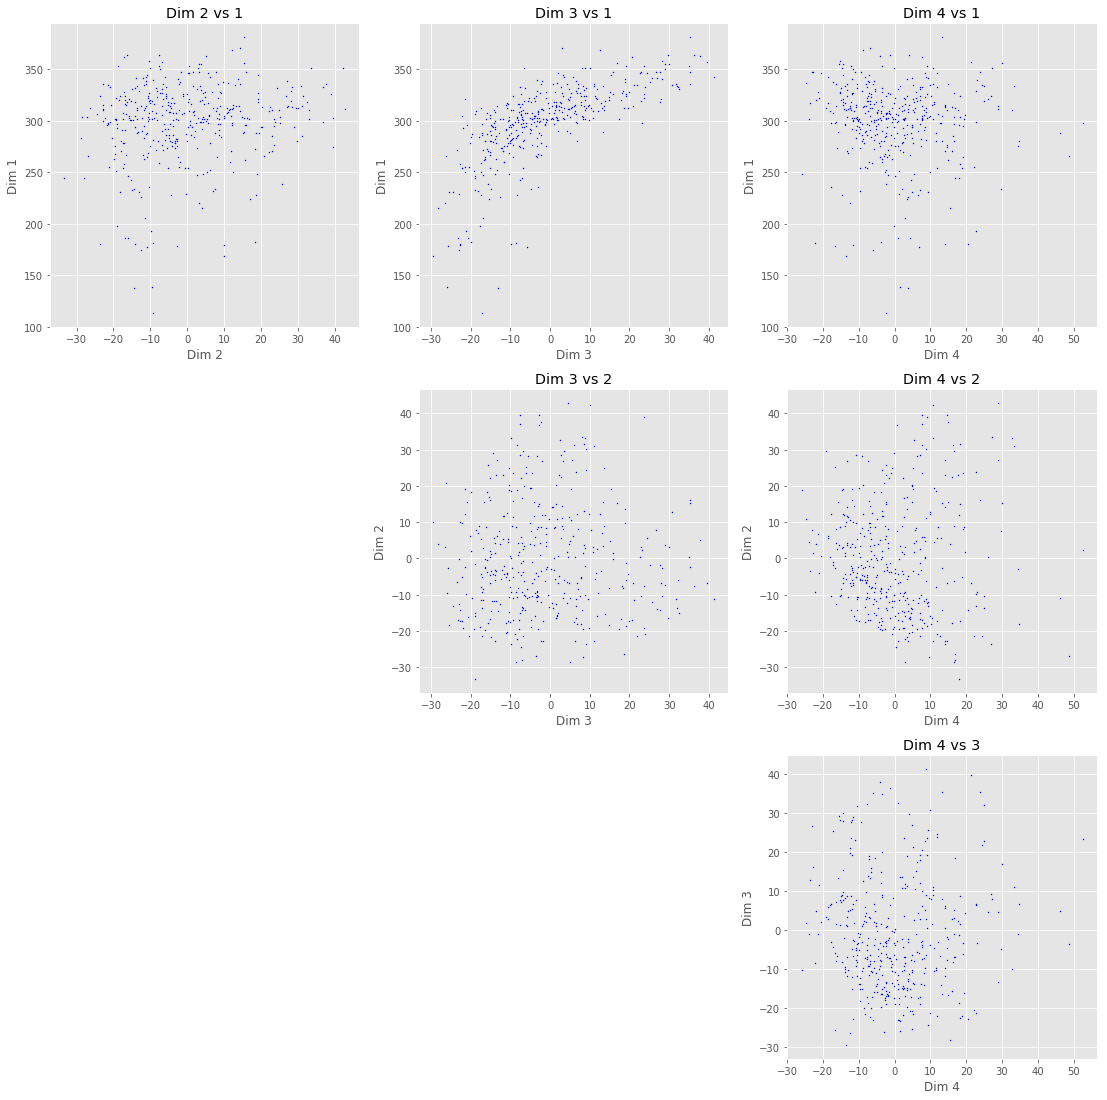

In [14]:
numdims = coords.shape[1]

plt.figure(figsize=(20, 20))
s = 2
axrange = 30

numrows = numdims
for i in range(numrows):
    for j in range(i+1):
        if i != j:
            plotnum = j*(numrows)+i+1
            plt.subplot(numrows, numrows, plotnum)
            sa = plt.scatter(coords[:,i],coords[:,j], color='b', s=s, lw=0, label='PCA')
            ta = plt.title("Dim %d vs %d"%(i+1,j+1))
            xl = plt.xlabel("Dim %d"%(i+1))
            yl = plt.ylabel("Dim %d"%(j+1))
            #plt.xlim([-axrange,axrange])
            #plt.ylim([-axrange,axrange])
            plt.tight_layout()

In [15]:
targettitles = [
    "Monopoly", # low rated mass market
    "Apples to Apples", # higher rated mass market and party
    "Zombicide", # Thematic co-op, adult theme, miniatures
    "Mice and Mystics", # Thematic co-op, family theme, miniatures
    "Love Letter", # social deduction, party, "filler"
    "Ticket to Ride", # very light-weight gateway eurogame 
    "Catan", # light-weight gateway eurogame
    "Carcassonne", # light-weight gateway eurogame
    "Agricola", # mid-weight eurogame 
    "Terraforming Mars", # mid-heavy-weight eurogame
    "Caverna: The Cave Farmers" # heavy eurogame
    ]

# number of recommended games to present
num2recommend = 5

# get game titles from titledata
gametitles = titledata.title[rp.index].values

# give recommendations for each target game 
for title in targettitles:
    recs = recommend_games(title, gametitles, coords, num2recommend)
    print('If you like %s, you should try: %s\n' % 
          (title, ', '.join(gametitles[recs])))

If you like Monopoly, you should try: Battleship, The Game of Life, UNO, Exploding Kittens, Checkers

If you like Apples to Apples, you should try: Bananagrams, Scattergories, Once Upon a Time: The Storytelling Card Game, Rummikub, Stratego

If you like Zombicide, you should try: Thunderstone, Pathfinder Adventure Card Game: Rise of the Runelords – Base Set, Shadows over Camelot, Discworld: Ankh-Morpork, Tales of the Arabian Nights

If you like Mice and Mystics, you should try: Fury of Dracula (third edition), Blood Bowl: Team Manager – The Card Game, Merchants & Marauders, Ghost Stories, Sentinels of the Multiverse

If you like Love Letter, you should try: Dixit Odyssey, Telestrations, Dixit Quest, Thebes, Carcassonne: Expansion 2 – Traders & Builders

If you like Ticket to Ride, you should try: Ticket to Ride: Europe, Carcassonne, Ticket to Ride: USA 1910, Ticket to Ride: Nordic Countries, Jaipur

If you like Catan, you should try: Mr. Jack, Bohnanza, Coloretto, No Thanks!, Red7

If 

## Cluster analysis using KMeans clustering

Let's see how KMeans clustering will group the games based on the SVD features.


Function to plot clustered feature results in two feature dimensions. 

Plots KMeans centroids, and if you provide the text symbols for every datapoint, it will plot them too.

In [16]:
def plot_cluster_map(coords, cluster_labels, symbols=[], centroids=[None], show_symbols=False):

    # get axis object
    ax = plt.gca()
    
    # hide gridlines
    ax.grid(False)
    
    # set axis spines color
    ax.spines['bottom'].set_color('k')
    ax.spines['top'].set_color('w') 
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('k')

    # set background color to black
    #ax.set_facecolor((.8, .8, .8))
    #ax.set_facecolor('k')
    ax.set_facecolor('w')
    
    # Plot the nodes 
    plt.scatter(coords[:,0], coords[:,1], s=20, c=cluster_labels, cmap=plt.cm.spectral)
    
    # plot centroids, if they were passed
    if len(centroids) > 0:
        #plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=100, linewidths = 5, zorder = 10)
        for i in range(centroids.shape[0]):
            plt.text(centroids[i, 0],centroids[i, 1], str(i+1), size=15,
                     bbox=dict(facecolor=(1,.7,.7),edgecolor='w',alpha=.7) )

    # Add a stock symbol label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    if symbols and show_symbols:
        for index, (symbol, label, (x, y)) in enumerate(
                zip(symbols, cluster_labels, coords)):

            dx = x - coords[:,0]
            dx[index] = 1
            dy = y - coords[:,1]
            dy[index] = 1
            this_dx = dx[np.argmin(np.abs(dy))]
            this_dy = dy[np.argmin(np.abs(dx))]
            if this_dx > 0:
                horizontalalignment = 'left'
                x = x + .002
            else:
                horizontalalignment = 'right'
                x = x - .002
            if this_dy > 0:
                verticalalignment = 'bottom'
                y = y + .002
            else:
                verticalalignment = 'top'
                y = y - .002
            #plt.text(x, y, name, size=10,
            plt.text(x, y, symbol, size=15,
                     horizontalalignment=horizontalalignment,
                     verticalalignment=verticalalignment,
                     bbox=dict(facecolor='w',
                     #          edgecolor=plt.cm.spectral(label / float(n_labels)),
                               edgecolor='w',
                               alpha=.4)
                    )

    plt.xlim(coords[:,0].min() - .05 * coords[:,0].ptp(),
             coords[:,0].max() + .05 * coords[:,0].ptp(),)
    plt.ylim(coords[:,1].min() - .03 * coords[:,1].ptp(),
             coords[:,1].max() + .03 * coords[:,1].ptp())


## Do the cluster analysis. 

Here, I use KMeans clustering, which is pretty straightforward, though you do need to specify the number of clusters to generate. It might make more sense to use a clustering method that auto-generates clusters, however, this data isn't inherently "clustery" (i.e., ther are few separable clusters of points).

In [17]:
from sklearn.cluster import KMeans

numclusters = 8

# cluster 
kmeans = KMeans(n_clusters=numclusters).fit(coords)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

func to draw a 2D scatterplot of labelled N dimensional feature data. 

The func first plots feature dim 1 vs dim 2 as a large graph, then all pairwise dimensions.

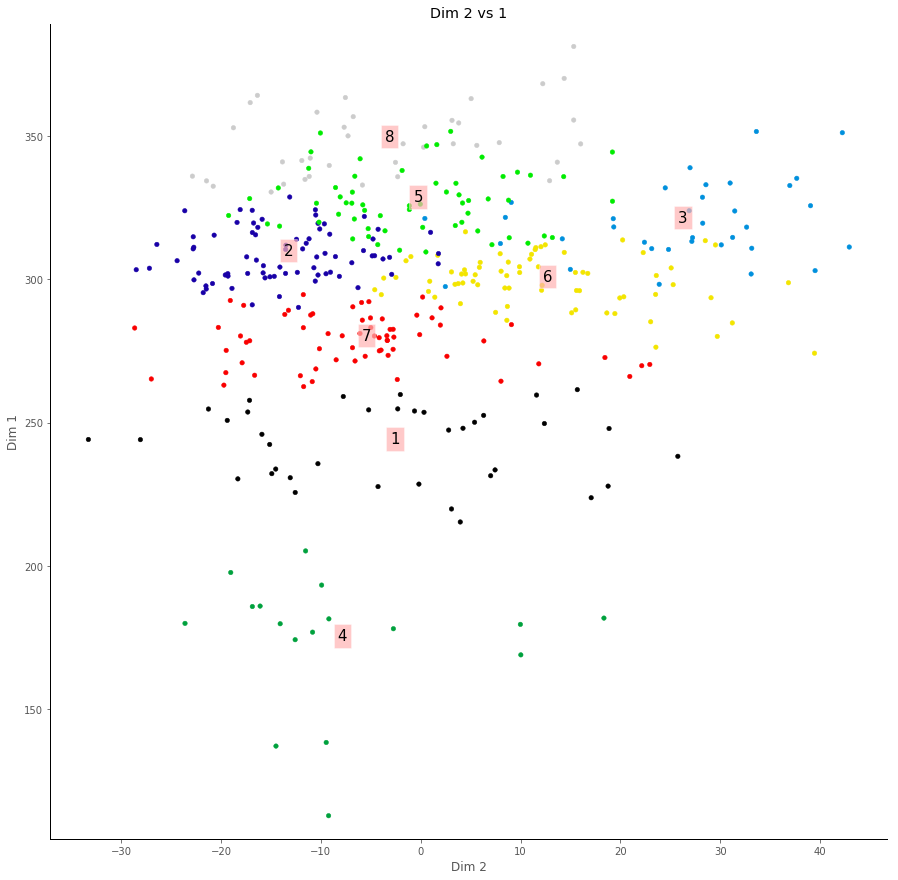

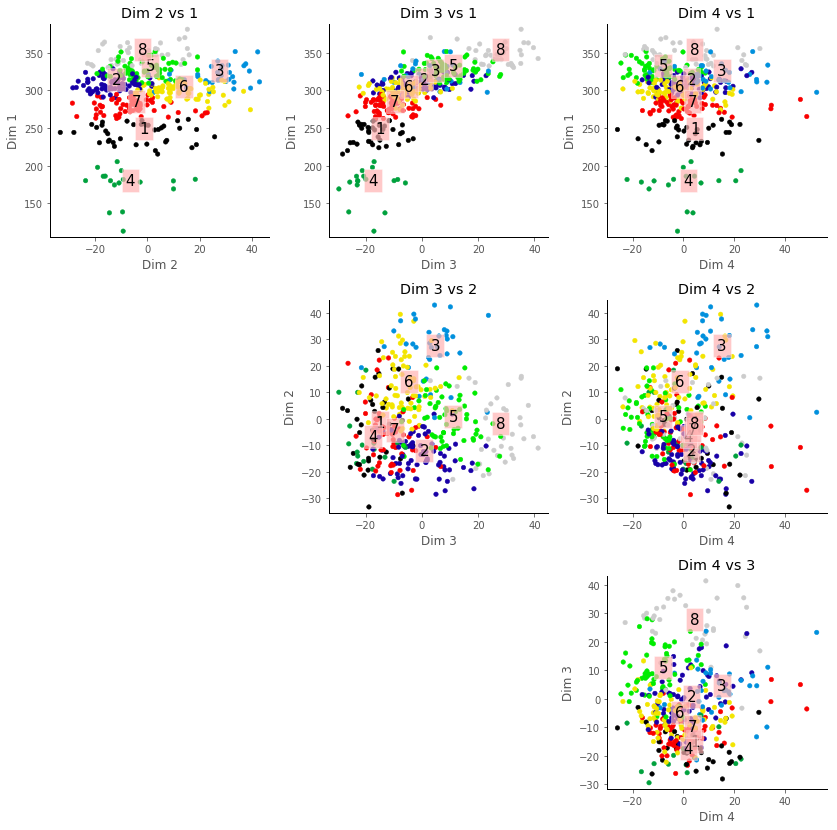

In [20]:
numdims = coords.shape[1]

plt.figure(figsize=(15, 15))
i=1
j=0
plot_cluster_map(coords[:,[i,j]], labels, symbols=[], centroids=centroids[:,[i,j]])
ta = plt.title("Dim %d vs %d"%(i+1,j+1))
xl = plt.xlabel("Dim %d"%(i+1))
yl = plt.ylabel("Dim %d"%(j+1))

plt.figure(figsize=(15, 15))

s = 2
axrange = 30

numrows = numdims
for i in range(numrows):
    for j in range(i+1):
        if i != j:
            plotnum = j*(numrows)+i+1
            plt.subplot(numrows, numrows, plotnum)
            plot_cluster_map(coords[:,[i,j]], labels, symbols=[], centroids=centroids[:,[i,j]])
            ta = plt.title("Dim %d vs %d"%(i+1,j+1))
            xl = plt.xlabel("Dim %d"%(i+1))
            yl = plt.ylabel("Dim %d"%(j+1))
            #plt.xlim([-axrange,axrange])
            #plt.ylim([-axrange,axrange])
            plt.tight_layout()

In [21]:
names = titledata.title[rp.index].values

n_labels = np.unique(labels).shape[0]

for i in range(n_labels):
    print('Cluster %i: contains %d games: %s\n' % 
          ((i + 1), len((names[labels == i])), ', '.join(names[labels == i])))

Cluster 1: contains 37 games: Apples to Apples, Axis & Allies, Guillotine, Pit, Scrabble, HeroQuest, Rummikub, Mystery of the Abbey, The Great Dalmuti, Taboo, SET, Labyrinth, Once Upon a Time: The Storytelling Card Game, Risk 2210 A.D., Stratego, Scattergories, Backgammon, Catan: 5-6 Player Extension, Pirate's Cove, BANG!, Jungle Speed, Gloom, Carcassonne: Expansion 3 – The Princess & The Dragon, Tsuro, The Werewolves of Miller's Hollow, Bananagrams, Talisman (Revised 4th Edition), BANG! The Bullet!, Red November, Monopoly Deal Card Game, Castle Panic, Cards Against Humanity, Zombie Dice, Smash Up, Boss Monster: The Dungeon Building Card Game, Dungeon Roll, Mascarade

Cluster 2: contains 77 games: Samurai, Acquire, Bohnanza, Catan, Liar's Dice, Medici, Chinatown, Lost Cities, Tikal, Torres, Modern Art, PitchCar, For Sale, Tichu, 6 nimmt!, Magic: The Gathering, Taj Mahal, Through the Desert, Battle Line, Carcassonne, Genoa, Blokus, Hive, Carcassonne: Expansion 1 – Inns & Cathedrals, Lor